In this notebook, we replicate the methodology from [Wilcox et al (2023)](http://www.colinphillips.net/wp-content/uploads/2023/02/wilcox2022.pdf), evaluating a suite of LSTM & Transformer language models on various syntactic constructions.

The first set of experiments the paper reports is on filler-gap dependencies. These are based on Example 5a from the paper, using the 2x2 design described in section 3 (wh/that x +gap/-gap). In this example, `the businessman` is in the gap position.

In [1]:
wh_gap = "I know who without thinking showed the slides to the guests after lunch."
that_gap = "I know that without thinking showed the slides to the guests after lunch."
wh_no_gap = "I know who without thinking the businessman showed the slides to the guests after lunch."
that_no_gap = "I know that without thinking the businessman showed the slides to the guests after lunch"

For now, we compute GPT2 surprisal. It's the easiest to use out of the box, though we may want to use something like [LMZoo](https://github.com/cpllab/lm-zoo) if we can get it to work in Python (I tried this prior to getting GPT2 working), or if our data format can work with its CLI. Wilcox et al compare the surprisal of the token after the gap (the critical region) in grammatical and ungrammatical conditions. For the examples above, it is `showed`. 

In [2]:
import sys

sys.path.insert(0, "/Users/sathvik/Desktop/umd/lm-generalization/src/")

In [3]:
import surprisal
from minicons import scorer

In [9]:
gpt2 = scorer.IncrementalLMScorer("gpt2")
def compute_wh_effect(model, wh_sentence, that_sentence, crit_region):
    surprisals = model.token_score([wh_sentence, that_sentence], surprisal = True, base_two = True)
    critical_surprisals = [token_score[1] for sentence in surprisals for token_score in sentence
                           if token_score[0] == crit_region]
    return critical_surprisals[0] - critical_surprisals[1]

Using pad_token, but it is not set yet.


In [14]:
compute_wh_effect(gpt2, wh_gap, that_gap, "showed")

-6.653267860412598

In [15]:
compute_wh_effect(gpt2, wh_no_gap, that_no_gap, "showed")

0.5451717376708984

This is in line with the result in Figure 4 of the paper: the wh-effect is negative in the +gap condition and positive in the -gap condition. This means the word after the gap is more surprising in the ungrammatical cases.

## Plotting by-word surprisals

In [16]:
import matplotlib.pyplot as plt

In [10]:
surprisals = gpt2.token_score([wh_gap, that_gap], surprisal = True, base_two = True)
get_index_item = lambda lst, index: [item[index] for item in lst]
wh_surprisal, that_surprisal = [get_index_item(sentence, 1) for sentence in surprisals]

def plot_wh_that_effect(wh_sent, that_sent, wh_surprisal, that_surprisal):
    words = wh_sent
    words = words.replace("who", "who/that")
    x_axis = words.split(" ")
    fig, ax = plt.subplots(1,1, figsize = (12, 8))
    ax.plot(wh_surprisal, label = "who")
    ax.plot(that_surprisal, label = "that")
    ax.set_xticks(range(len(x_axis)))
    ax.set_xticklabels(x_axis)
    ax.legend()
    plt.show()

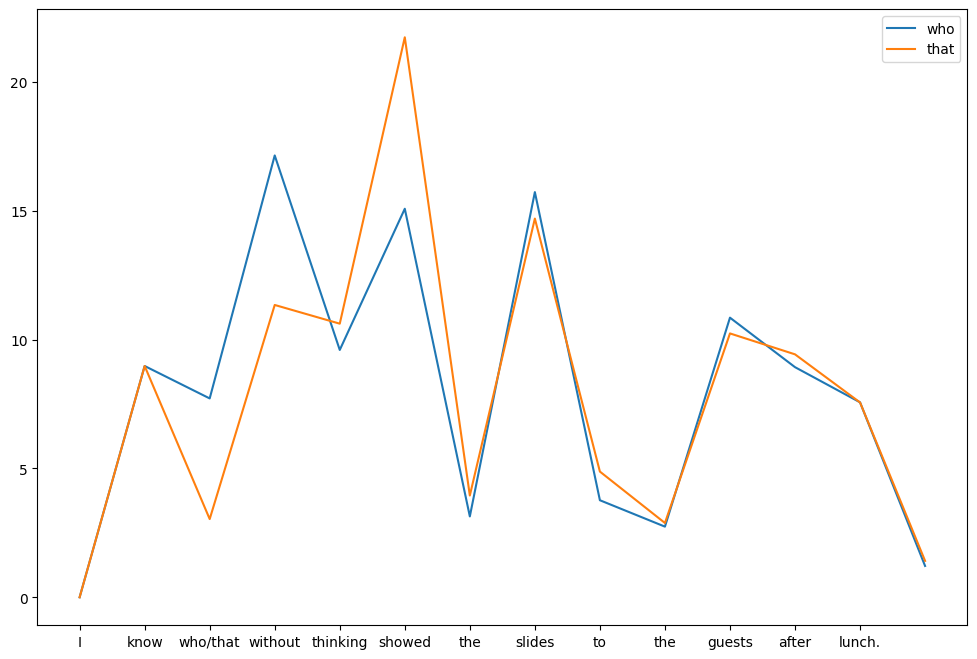

In [62]:
plot_wh_that_effect(wh_gap, that_gap, wh_surprisal, that_surprisal)

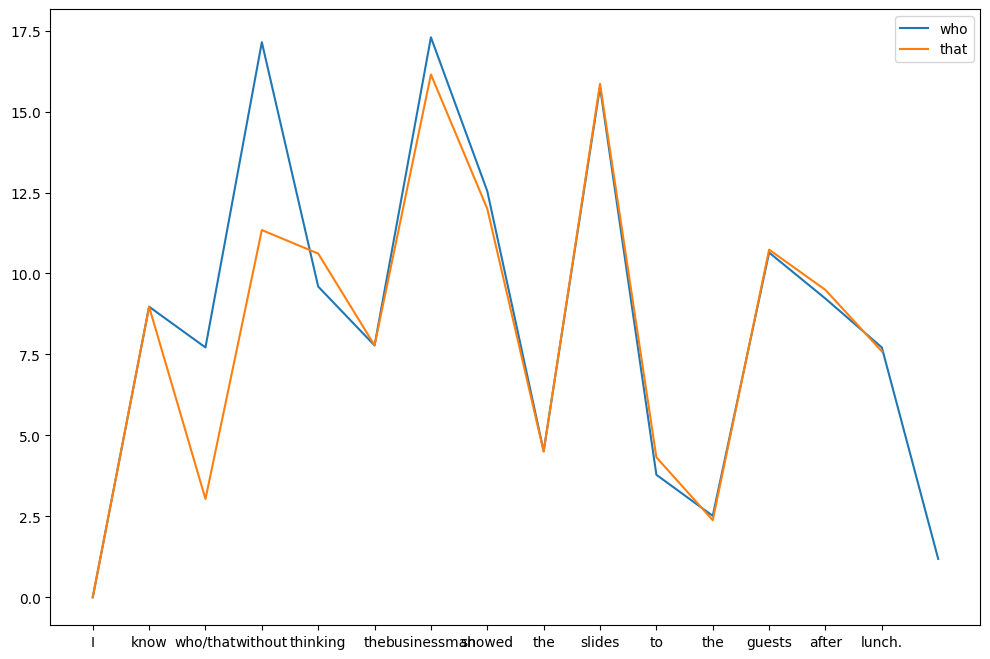

In [18]:
surprisals = gpt2.token_score([wh_no_gap, that_no_gap], surprisal = True, base_two = True)
get_index_item = lambda lst, index: [item[index] for item in lst]
wh_surprisal, that_surprisal = [get_index_item(sentence, 1) for sentence in surprisals]
plot_wh_that_effect(wh_no_gap, that_no_gap, wh_surprisal, that_surprisal)

We next try to replicate this result using the Gulordava (2018) RNN (GRNN).

In [4]:
import os
import sys
import torch
import torch.nn.functional as F

sys.path.insert(0, "/Users/sathvik/Desktop/umd/lm-generalization/src/")

In [12]:
from colorlessgreenRNNs.src.language_models.model import RNNModel
from colorlessgreenRNNs.src.language_models.dictionary_corpus import Dictionary


In [13]:
import os
root_dir = "/".join(os.getcwd().split("/")[:-1])


In [14]:
model_file = "../models/hidden650_batch128_dropout0.2_lr20.0.pt"
model = torch.load(model_file, map_location = torch.device("cpu"))
grnn = RNNModel(model.rnn_type, model.encoder.num_embeddings, 
                     model.nhid, model.nhid, model.nlayers, 0.2, False)
grnn.load_state_dict(model.state_dict())
grnn.eval()

/Users/sathvik/Desktop/umd/lm-generalization/lm-gen-env/lib/python3.8/site-packages/torch/serialization.py:868: SourceChangeWarning: source code of class 'model.RNNModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/sathvik/Desktop/umd/lm-generalization/lm-gen-env/lib/python3.8/site-packages/torch/serialization.py:868: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/sathvik/Desktop/umd/lm-generalization/lm-gen-env/lib/python3.8/site-packages/torch/serialization.py:868: SourceChangeWarning: source code of class 'torch.nn.modules.sparse

RNNModel(
  (drop): Dropout(p=0.2, inplace=False)
  (encoder): Embedding(50001, 650)
  (rnn): LSTM(650, 650, num_layers=2, dropout=0.2)
  (decoder): Linear(in_features=650, out_features=50001, bias=True)
)

In [18]:
os.getcwd()

'/Users/sathvik/Desktop/umd/lm-generalization/notebooks'

In [26]:
vocab = Dictionary("../data/lm-data/") # takes in a directory
# from https://github.com/caplabnyu/sapbenchmark/blob/main/Surprisals/get_lstm.py

def indexify(word):
    """ Convert word to an index into the embedding matrix """
    if word not in vocab.word2idx:
        print("Warning: {} not in vocab".format(word))
    return vocab.word2idx[word] if word in vocab.word2idx else vocab.word2idx["<unk>"]

def tokenize(sent):
    sent = sent.strip()
    if sent == "": return []

    # respect commas as a token
    sent = " ,".join(sent.split(","))

    # same w/ EOS punctuation (but not . in abbreviations)
    if sent[-1] in  [".", "?", "!"]:
        sent = sent[:-1] + " " + sent[-1]

    if ("." in sent) & (sent[-1] != "."):
        print(sent)

    # split on 's
    sent = " 's".join(sent.split("'s"))

    # split on n't
    sent = " n't".join(sent.split("n't"))

    return sent.split()


In [27]:
def grnn_surprisal(sentence):
    sentence = ["<eos>"] + tokenize(sentence) # EOS prepend
    rnn_input = torch.LongTensor([indexify(w.lower()) for w in sentence])
    out, _ = grnn(rnn_input.view(-1, 1), model.init_hidden(1))
    output_flat = out.view(-1, len(vocab))
    return [-F.log_softmax(out[i], dim=-1).view(-1)[word_idx].item() for i, (word_idx, word)
 in enumerate(zip(rnn_input, sentence))][1:-1]

In [5]:
sys.path.insert(0, "/Users/sathvik/Desktop/umd/lm-generalization/src/colorlessgreenRNNs/src/language_models")

In [6]:
model, grnn = surprisal.load_rnn("../models/hidden650_batch128_dropout0.2_lr20.0.pt")
lstm_vocab = surprisal.load_vocab("../data/lm-data")

/Users/sathvik/Desktop/umd/lm-generalization/lm-gen-env/lib/python3.8/site-packages/torch/serialization.py:868: SourceChangeWarning: source code of class 'model.RNNModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/sathvik/Desktop/umd/lm-generalization/lm-gen-env/lib/python3.8/site-packages/torch/serialization.py:868: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/sathvik/Desktop/umd/lm-generalization/lm-gen-env/lib/python3.8/site-packages/torch/serialization.py:868: SourceChangeWarning: source code of class 'torch.nn.modules.sparse

In [12]:
import matplotlib.pyplot as plt

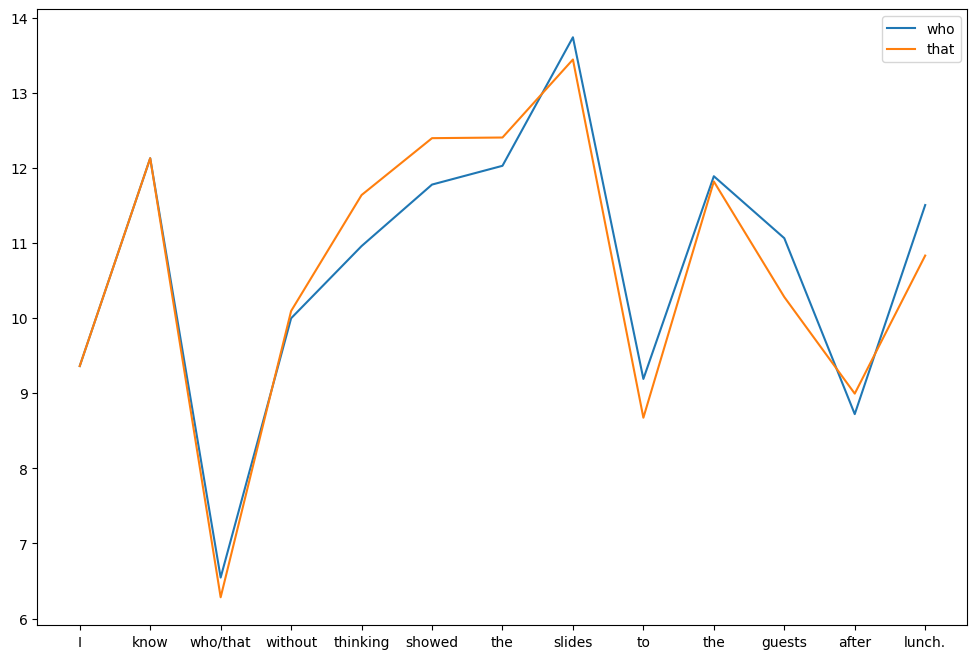

In [13]:
wh_surprisal, that_surprisal = surprisal.grnn_surprisal(model, grnn, lstm_vocab, wh_gap), surprisal.grnn_surprisal(model, grnn, lstm_vocab, that_gap)
plot_wh_that_effect(wh_gap, that_gap, wh_surprisal, that_surprisal)

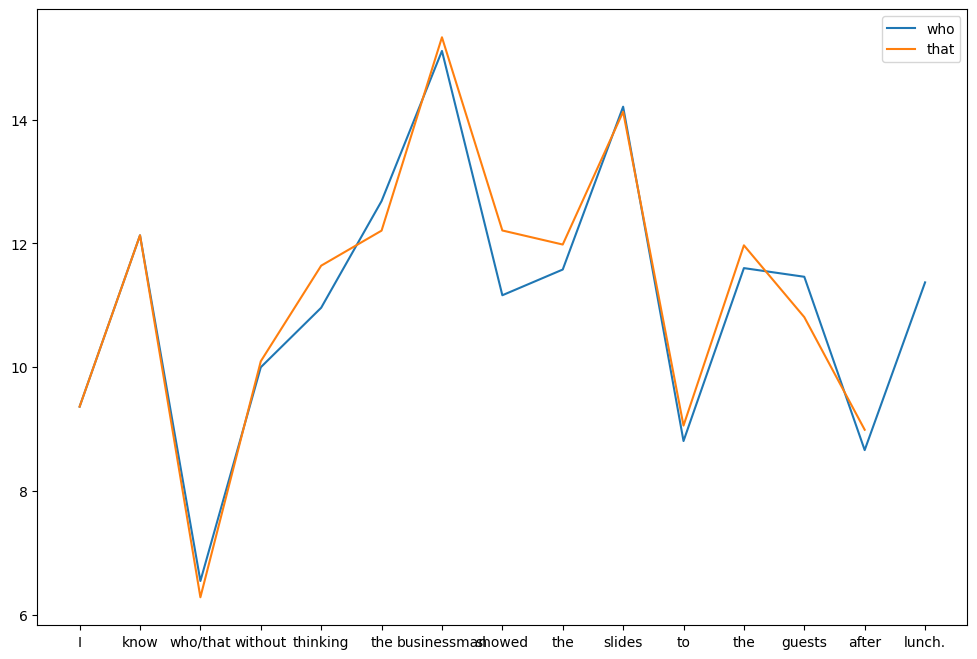

In [15]:
wh_surprisal, that_surprisal = surprisal.grnn_surprisal(model, grnn, lstm_vocab, wh_no_gap), surprisal.grnn_surprisal(model, grnn, lstm_vocab, that_no_gap)
plot_wh_that_effect(wh_no_gap, that_no_gap, wh_surprisal, that_surprisal)

The effect is smaller here - we should figure out the differences between the GPT2 and LSTM surprisal computations, GPT2 starts at 0 and we don't know how the beginning/end of sentence padding works.